<a href="https://colab.research.google.com/github/RachelZhou287/542_Final/blob/main/BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torchvision
print(torchvision.__version__)
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
# ! pip install pyro-ppl
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.poutine as poutine

0.23.0+cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 18.6 MB/s eta 0:00:00


In [ ]:
# Test integrity first
!tar -tzf /content/CUB_200_2011.tgz > /dev/null


In [2]:
# Extract safely
!mkdir -p /content/data
!tar -xzf /content/CUB_200_2011.tgz -C /content/data/

In [3]:
# Confirm
!ls /content/data/CUB_200_2011 | head

attributes
bounding_boxes.txt
classes.txt
image_class_labels.txt
images
images.txt
parts
README
train_test_split.txt


# Load dataset

In [4]:

class CUBDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform

        img_files = pd.read_csv(os.path.join(root, "images.txt"), sep=" ", names=["img_id", "filepath"])
        labels = pd.read_csv(os.path.join(root, "image_class_labels.txt"), sep=" ", names=["img_id", "target"])
        split = pd.read_csv(os.path.join(root, "train_test_split.txt"), sep=" ", names=["img_id", "is_training_img"])
        df = img_files.merge(labels, on="img_id").merge(split, on="img_id")
        df = df[df["is_training_img"] == int(train)]

        self.paths = df["filepath"].values
        self.targets = df["target"].values - 1  # 0-indexed

    def __len__(self):  return len(self.paths) # number of samples

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.paths[idx])
        img = Image.open(img_path).convert("RGB")
        label = self.targets[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# === Transforms + loaders ===
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

data_root = "/content/data/CUB_200_2011"
train_data = CUBDataset(data_root, train=True, transform=transform)
test_data  = CUBDataset(data_root, train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2) #batch size: group 32 images per training step
test_loader  = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=2)

print(f"✅ Loaded {len(train_data)} training and {len(test_data)} testing images.")


✅ Loaded 5994 training and 5794 testing images.


# NN Structure

In [ ]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Flatten 3×128×128 RGB images → [batch, 49152]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.out(x)  # raw logits (no softmax)
        return x


# Initialize network
input_size = 3 * 64 * 64
net = NN(input_size=input_size, hidden_size=128, output_size=200)

# Model

In [ ]:
def model(x_data, y_data):
    # Normal(0,1) priors on all weights and biases
    fc1w_prior = Normal(torch.zeros_like(net.fc1.weight),
                        torch.ones_like(net.fc1.weight)).to_event(2)
    fc1b_prior = Normal(torch.zeros_like(net.fc1.bias),
                        torch.ones_like(net.fc1.bias)).to_event(1)
    outw_prior = Normal(torch.zeros_like(net.out.weight),
                        torch.ones_like(net.out.weight)).to_event(2)
    outb_prior = Normal(torch.zeros_like(net.out.bias),
                        torch.ones_like(net.out.bias)).to_event(1)

    priors = {
        'fc1.weight': fc1w_prior,
        'fc1.bias': fc1b_prior,
        'out.weight': outw_prior,
        'out.bias': outb_prior
    }

    lifted_model = pyro.random_module("module", net, priors)
    lifted_reg_model = lifted_model()  # one sample of network parameters

    # Forward pass
    logits = lifted_reg_model(x_data)

    # Each image is an independent observation
    with pyro.plate("data", x_data.size(0)):
        pyro.sample("obs", Categorical(logits=logits), obs=y_data)

# Guide

In [ ]:
soft_plus = torch.nn.Softplus()

def guide(x_data, y_data):
    # Layer 1 weight posterior
    fc1w_mu = pyro.param("fc1w_mu", torch.randn_like(net.fc1.weight))
    fc1w_sigma_param = pyro.param("fc1w_sigma", torch.ones_like(net.fc1.weight))
    fc1w_sigma = soft_plus(fc1w_sigma_param)
    fc1w_dist = Normal(fc1w_mu, fc1w_sigma).to_event(2)

    # Layer 1 bias posterior
    fc1b_mu = pyro.param("fc1b_mu", torch.randn_like(net.fc1.bias))
    fc1b_sigma_param = pyro.param("fc1b_sigma", torch.ones_like(net.fc1.bias))
    fc1b_sigma = soft_plus(fc1b_sigma_param)
    fc1b_dist = Normal(fc1b_mu, fc1b_sigma).to_event(1)

    # Output layer weight posterior
    outw_mu = pyro.param("outw_mu", torch.randn_like(net.out.weight))
    outw_sigma_param = pyro.param("outw_sigma", torch.ones_like(net.out.weight))
    outw_sigma = soft_plus(outw_sigma_param)
    outw_dist = Normal(outw_mu, outw_sigma).to_event(2)

    # Output layer bias posterior
    outb_mu = pyro.param("outb_mu", torch.randn_like(net.out.bias))
    outb_sigma_param = pyro.param("outb_sigma", torch.ones_like(net.out.bias))
    outb_sigma = soft_plus(outb_sigma_param)
    outb_dist = Normal(outb_mu, outb_sigma).to_event(1)

    dists = {
        'fc1.weight': fc1w_dist,
        'fc1.bias': fc1b_dist,
        'out.weight': outw_dist,
        'out.bias': outb_dist
    }

    lifted_module = pyro.random_module("module", net, dists)
    return lifted_module()


# Whole
* With KL penaliztion

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro
from pyro.distributions import Normal, Categorical
import pyro.poutine as poutine


# ======================================================
# 1️⃣ Define NN architecture
# ======================================================
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Flatten 3×128×128 RGB images → [batch, 49152]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.out(x)  # raw logits (no softmax)
        return x


# Initialize network
input_size = 3 * 64 * 64
net = NN(input_size=input_size, hidden_size=128, output_size=200)


# ======================================================
# 2️⃣ Define Bayesian model
# ======================================================
def model(x_data, y_data, beta_kl=1.0):
    # Normal(0,1) priors on all weights and biases
    fc1w_prior = Normal(torch.zeros_like(net.fc1.weight),
                        torch.ones_like(net.fc1.weight)).to_event(2)
    fc1b_prior = Normal(torch.zeros_like(net.fc1.bias),
                        torch.ones_like(net.fc1.bias)).to_event(1)
    outw_prior = Normal(torch.zeros_like(net.out.weight),
                        torch.ones_like(net.out.weight)).to_event(2)
    outb_prior = Normal(torch.zeros_like(net.out.bias),
                        torch.ones_like(net.out.bias)).to_event(1)

    priors = {
        'fc1.weight': fc1w_prior,
        'fc1.bias': fc1b_prior,
        'out.weight': outw_prior,
        'out.bias': outb_prior
    }

    with poutine.scale(scale=beta_kl):
        lifted_model = pyro.random_module("module", net, priors)
        sampled_net = lifted_model()

    # Forward pass
    logits = sampled_net(x_data)

    # Each image is an independent observation
    with pyro.plate("data", x_data.size(0)):
        pyro.sample("obs", Categorical(logits=logits), obs=y_data)


# ======================================================
# 3️⃣ Define Guide (Variational Posterior)
# ======================================================
soft_plus = torch.nn.Softplus()

def guide(x_data, y_data,beta_kl=1.0):
    # Layer 1 weight posterior
    fc1w_mu = pyro.param("fc1w_mu", torch.randn_like(net.fc1.weight))
    fc1w_sigma_param = pyro.param("fc1w_sigma", torch.ones_like(net.fc1.weight))
    fc1w_sigma = soft_plus(fc1w_sigma_param)
    fc1w_dist = Normal(fc1w_mu, fc1w_sigma).to_event(2)

    # Layer 1 bias posterior
    fc1b_mu = pyro.param("fc1b_mu", torch.randn_like(net.fc1.bias))
    fc1b_sigma_param = pyro.param("fc1b_sigma", torch.ones_like(net.fc1.bias))
    fc1b_sigma = soft_plus(fc1b_sigma_param)
    fc1b_dist = Normal(fc1b_mu, fc1b_sigma).to_event(1)

    # Output layer weight posterior
    outw_mu = pyro.param("outw_mu", torch.randn_like(net.out.weight))
    outw_sigma_param = pyro.param("outw_sigma", torch.ones_like(net.out.weight))
    outw_sigma = soft_plus(outw_sigma_param)
    outw_dist = Normal(outw_mu, outw_sigma).to_event(2)

    # Output layer bias posterior
    outb_mu = pyro.param("outb_mu", torch.randn_like(net.out.bias))
    outb_sigma_param = pyro.param("outb_sigma", torch.ones_like(net.out.bias))
    outb_sigma = soft_plus(outb_sigma_param)
    outb_dist = Normal(outb_mu, outb_sigma).to_event(1)

    dists = {
        'fc1.weight': fc1w_dist,
        'fc1.bias': fc1b_dist,
        'out.weight': outw_dist,
        'out.bias': outb_dist
    }

    # KL scaling
    with poutine.scale(scale=beta_kl):
        lifted_model = pyro.random_module("module", net, dists)


    return lifted_model()


# ======================================================
# 4️⃣ Training Loop (SVI)
# ======================================================
pyro.clear_param_store()

beta_kl = 0.5
optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_id, (x, y) in enumerate(train_loader):
        x = x.view(x.size(0), -1)  # Flatten
        y = y.long()               # Ensure class indices
        loss = svi.step(x, y)
        total_loss += loss

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1} | β={beta_kl:.2f} | Avg. Loss: {avg_loss:.4f}")


/usr/local/lib/python3.12/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


Epoch 1 | β=0.50 | Avg. Loss: 21859.4373
Epoch 2 | β=0.50 | Avg. Loss: 1384.6310
Epoch 3 | β=0.50 | Avg. Loss: 554.7148
Epoch 4 | β=0.50 | Avg. Loss: 570.7322
Epoch 5 | β=0.50 | Avg. Loss: 588.3781


# Posterior Samplying

In [9]:
@torch.no_grad()
def predict(x,K=10):
  sample_models=[guide[None,None] for _ in range(K)]
  yhats=[]
  for sample_nets in sample_models:
    logits=sample_nets(x.view(x.size(0), -1))
    yhats.append(F.softmax(logits,dim=1))
  yhats=torch.stack(yhats)  # [K, batch, num_classes]
  mean_probs=yhats.mean(0)
  var_probs=yhats.var(1)
  return mean_probs,var_probs

# Rejection Threshold

In [10]:
def test_batch(x , y, threshold=0.7):
  prob=predict(x)
  label=prob.argmax(1)
  maxProb=prob.max(1).values

  confident=maxProb > threshold
  correct=(label[confident]==y[confident]).sum().item()
  total=y.size(0)
  total_confident=confident.sum().item()

  if total_confident >0:
    acc=correct/total_confident

  refused=1-total_confident/total # proportion without a label

  return acc,refused

# Visualize Uncertainty

In [11]:
def visualize_uncertainty(x, num_samples=10):
    mean_probs, var_probs = predict(x[:num_samples])
    plt.figure(figsize=(10, 3))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(x[i].permute(1,2,0).numpy())
        plt.axis('off')
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.bar(range(mean_probs.shape[1]), mean_probs[i].numpy())
    plt.show()


# Whole

Running on device: cuda
✅ Loaded 5994 training and 5794 testing images.


/usr/local/lib/python3.12/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


Epoch 1/50 | β=0.5 | Avg ELBO loss: 206081.1918
Epoch 2/50 | β=0.5 | Avg ELBO loss: 139458.6969
Epoch 3/50 | β=0.5 | Avg ELBO loss: 92080.6916
Epoch 4/50 | β=0.5 | Avg ELBO loss: 60066.5478
Epoch 5/50 | β=0.5 | Avg ELBO loss: 38903.9669
Epoch 6/50 | β=0.5 | Avg ELBO loss: 24991.6248
Epoch 7/50 | β=0.5 | Avg ELBO loss: 15966.9807
Epoch 8/50 | β=0.5 | Avg ELBO loss: 10233.6005
Epoch 9/50 | β=0.5 | Avg ELBO loss: 6572.4159
Epoch 10/50 | β=0.5 | Avg ELBO loss: 4328.8624
Epoch 11/50 | β=0.5 | Avg ELBO loss: 2958.8692
Epoch 12/50 | β=0.5 | Avg ELBO loss: 2193.7120
Epoch 13/50 | β=0.5 | Avg ELBO loss: 1683.7284
Epoch 14/50 | β=0.5 | Avg ELBO loss: 1417.3621
Epoch 15/50 | β=0.5 | Avg ELBO loss: 1277.3213
Epoch 16/50 | β=0.5 | Avg ELBO loss: 1242.6540
Epoch 17/50 | β=0.5 | Avg ELBO loss: 1200.3285
Epoch 18/50 | β=0.5 | Avg ELBO loss: 1162.0147
Epoch 19/50 | β=0.5 | Avg ELBO loss: 1203.0647
Epoch 20/50 | β=0.5 | Avg ELBO loss: 1231.1244
Epoch 21/50 | β=0.5 | Avg ELBO loss: 1231.0663
Epoch 22/50 

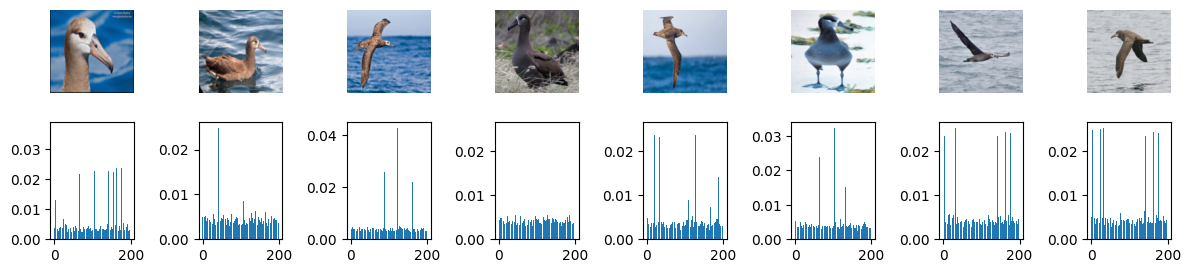

In [17]:
# ======================================================
# 📦 Imports and Setup
# ======================================================
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

import pyro
import pyro.poutine as poutine
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pyro.clear_param_store()
print(f"Running on device: {device}")

# ======================================================
# 🐦 1️⃣ CUB-200 Dataset Loader
# ======================================================
class CUBDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform

        img_files = pd.read_csv(os.path.join(root, "images.txt"), sep=" ", names=["img_id", "filepath"])
        labels = pd.read_csv(os.path.join(root, "image_class_labels.txt"), sep=" ", names=["img_id", "target"])
        split = pd.read_csv(os.path.join(root, "train_test_split.txt"), sep=" ", names=["img_id", "is_training_img"])
        df = img_files.merge(labels, on="img_id").merge(split, on="img_id")
        df = df[df["is_training_img"] == int(train)]

        self.paths = df["filepath"].values
        self.targets = df["target"].values - 1  # 0-indexed

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.paths[idx])
        img = Image.open(img_path).convert("RGB")
        label = self.targets[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# === Transforms + DataLoaders ===
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

data_root = "/content/data/CUB_200_2011"  # <-- Change if needed
train_data = CUBDataset(data_root, train=True, transform=transform)
test_data  = CUBDataset(data_root, train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

print(f"✅ Loaded {len(train_data)} training and {len(test_data)} testing images.")

# ======================================================
# 🧠 2️⃣ Neural Network Architecture
# ======================================================
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x  # logits

input_size = 3 * 128 * 128
hidden_size = 512
output_size = 200  # 200 bird species
net = NN(input_size, hidden_size, output_size).to(device)

# ======================================================
# 🔢 3️⃣ Model & Guide (β-ELBO scaling)
# ======================================================
soft_plus = nn.Softplus()

def model(x_data, y_data, beta_kl=0.5):
    fc1w_prior = Normal(torch.zeros_like(net.fc1.weight),
                        torch.ones_like(net.fc1.weight)).to_event(2)
    fc1b_prior = Normal(torch.zeros_like(net.fc1.bias),
                        torch.ones_like(net.fc1.bias)).to_event(1)
    outw_prior = Normal(torch.zeros_like(net.out.weight),
                        torch.ones_like(net.out.weight)).to_event(2)
    outb_prior = Normal(torch.zeros_like(net.out.bias),
                        torch.ones_like(net.out.bias)).to_event(1)
    priors = {
        "fc1.weight": fc1w_prior, "fc1.bias": fc1b_prior,
        "out.weight": outw_prior, "out.bias": outb_prior
    }

    with poutine.scale(scale=beta_kl):
        lifted_model = pyro.random_module("module", net, priors)
        sampled_net = lifted_model()

    logits = sampled_net(x_data)
    with pyro.plate("data", x_data.size(0)):
        pyro.sample("obs", Categorical(logits=logits), obs=y_data)

def guide(x_data, y_data, beta_kl=0.5):
    fc1w_mu = pyro.param("fc1w_mu", torch.randn_like(net.fc1.weight))
    fc1w_sigma = soft_plus(pyro.param("fc1w_sigma", torch.ones_like(net.fc1.weight)))
    fc1w_dist = Normal(fc1w_mu, fc1w_sigma).to_event(2)

    fc1b_mu = pyro.param("fc1b_mu", torch.randn_like(net.fc1.bias))
    fc1b_sigma = soft_plus(pyro.param("fc1b_sigma", torch.ones_like(net.fc1.bias)))
    fc1b_dist = Normal(fc1b_mu, fc1b_sigma).to_event(1)

    outw_mu = pyro.param("outw_mu", torch.randn_like(net.out.weight))
    outw_sigma = soft_plus(pyro.param("outw_sigma", torch.ones_like(net.out.weight)))
    outw_dist = Normal(outw_mu, outw_sigma).to_event(2)

    outb_mu = pyro.param("outb_mu", torch.randn_like(net.out.bias))
    outb_sigma = soft_plus(pyro.param("outb_sigma", torch.ones_like(net.out.bias)))
    outb_dist = Normal(outb_mu, outb_sigma).to_event(1)

    dists = {
        "fc1.weight": fc1w_dist, "fc1.bias": fc1b_dist,
        "out.weight": outw_dist, "out.bias": outb_dist
    }

    with poutine.scale(scale=beta_kl):
        lifted_module = pyro.random_module("module", net, dists)
        return lifted_module()

# ======================================================
# 🏋️‍♂️ 4️⃣ Train with SVI (β-ELBO)
# ======================================================
beta_kl = 0.5
optimizer = Adam({"lr": 0.005})
elbo = Trace_ELBO()
svi = SVI(lambda x,y: model(x,y,beta_kl),
          lambda x,y: guide(x,y,beta_kl),
          optimizer, loss=elbo)

num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        total_loss += svi.step(x, y)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} | β={beta_kl} | Avg ELBO loss: {avg_loss:.4f}")

# ======================================================
# 🔮 5️⃣ Posterior Prediction & Uncertainty Visualization
# ======================================================
@torch.no_grad()
def mc_predict(x, K=50):
    sampled_models = [guide(None, None) for _ in range(K)]
    yhats = []
    for sampled_net in sampled_models:
        sampled_net.to(device)
        logits = sampled_net(x.view(x.size(0), -1))
        yhats.append(F.softmax(logits, dim=1))
    yhats = torch.stack(yhats)         # [K, batch, classes]
    mean_probs = yhats.mean(0)
    var_probs = yhats.var(0)
    return mean_probs, var_probs

def test_batch(x, y, threshold=0.04, K=50):
    mean_probs, _ = mc_predict(x, K)
    label = mean_probs.argmax(1)
    maxProb = mean_probs.max(1).values
    confident = maxProb > threshold
    correct = (label[confident] == y[confident]).sum().item()
    total = y.size(0)
    total_confident = confident.sum().item()
    acc = correct / total_confident if total_confident > 0 else 0.0
    skip_rate = 1 - total_confident / total
    return acc, skip_rate

# Evaluate on a few batches
total_acc, total_skip = 0, 0
count = 0
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    acc, skip = test_batch(x, y, threshold=0.7, K=5)
    total_acc += acc
    total_skip += skip
    count += 1
print(f"✅ Mean Accuracy (confident): {100*total_acc/count:.2f}% | Skip rate: {100*total_skip/count:.2f}%")

# Visualize a few predictions
x_vis, y_vis = next(iter(test_loader))
mean_probs, var_probs = mc_predict(x_vis[:8].to(device))
plt.figure(figsize=(12, 3))
for i in range(8):
    plt.subplot(2, 8, i + 1)
    plt.imshow(x_vis[i].permute(1,2,0))
    plt.axis('off')
    plt.subplot(2, 8, 8 + i + 1)
    plt.bar(range(output_size), mean_probs[i].cpu())
plt.tight_layout()
plt.show()
